In [192]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [193]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.2.0


In [194]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Horsepower']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [195]:
dataset = raw_dataset.copy()
dataset.tail()

,,,,,,MPG,Horsepower
27.0,4,140.0,86.0,2790.0,15.6,82,1
44.0,4,97.0,52.0,2130.0,24.6,82,2
32.0,4,135.0,84.0,2295.0,11.6,82,1
28.0,4,120.0,79.0,2625.0,18.6,82,1
31.0,4,119.0,82.0,2720.0,19.4,82,1


In [196]:
dataset.isna().sum()
dataset = dataset.dropna()
# dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

print(train_dataset.describe().transpose())

            count       mean       std   min   25%   50%   75%   max
MPG         318.0  75.946541  3.705266  70.0  73.0  76.0  79.0  82.0
Horsepower  318.0   1.553459  0.799430   1.0   1.0   1.0   2.0   3.0


In [197]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [198]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,75.946541,3.705266
Horsepower,1.553459,0.799430


In [199]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
#print(normalizer.mean.numpy())

In [200]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = preprocessing.Normalization(input_shape=[1,])
horsepower_normalizer.adapt(horsepower)

horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: &quot;sequential_12&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_25 (Normalizat (None, 318)               637       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 319       
Total params: 956
Trainable params: 319
Non-trainable params: 637
_________________________________________________________________


In [201]:
horsepower_model.predict(horsepower[:10])


array([[-0.499],
       [-0.499],
       [-0.499],
       [-0.999],
       [-0.499],
       [-1.498],
       [-1.498],
       [-0.499],
       [-0.499],
       [-0.499]], dtype=float32)

In [202]:
import tensorflow as tf
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error')

In [203]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    epochs=300,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Wall time: 3.4 s


In [204]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
295,14.288418,13.510557,295
296,14.907066,12.402969,296
297,16.961787,12.443179,297
298,22.404533,27.626199,298
299,25.195055,22.032061,299


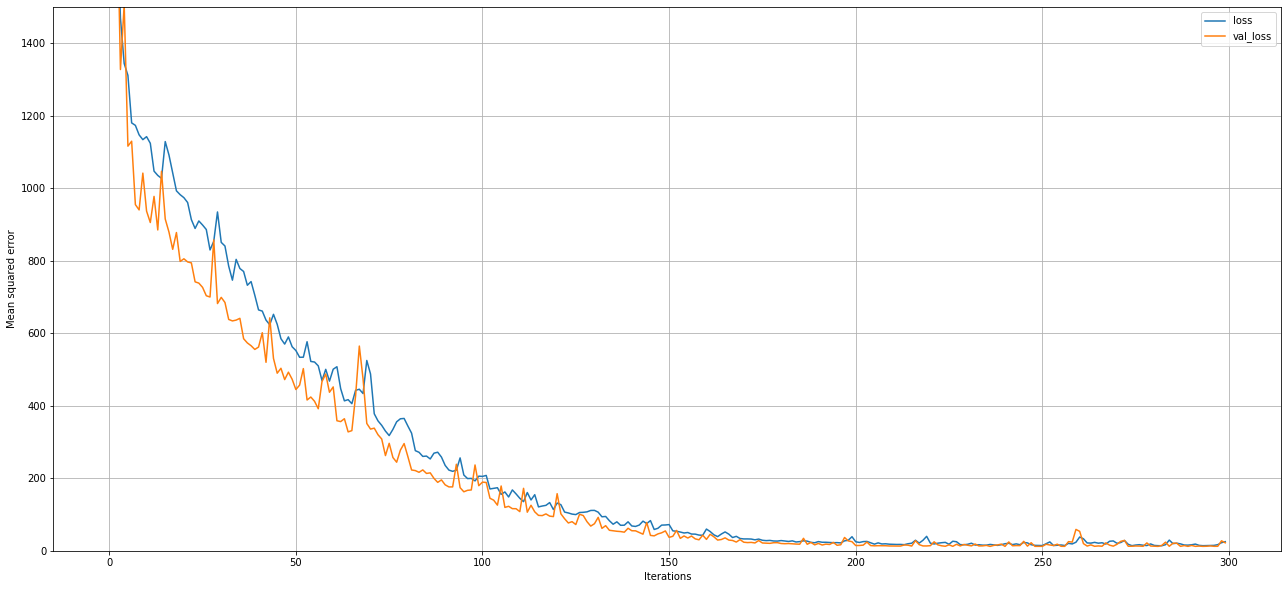

In [206]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1500])
  #plt.xlim([0, 1610])
  plt.xlabel('Iterations')
  plt.ylabel('Mean squared error')
  plt.legend()
  plt.grid(True)
plt.figure(figsize=(22,10))
plot_loss(history)
